In [5]:
import os

def count_files_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Directories
directories = ['plant_cnn/Train', 'plant_cnn/Test', 'plant_cnn/Validation']

# Count files in each directory
for directory in directories:
    count = count_files_in_directory(directory)
    print(f'Number of images in {directory}: {count}')

Number of images in plant_cnn/Train: 0
Number of images in plant_cnn/Test: 0
Number of images in plant_cnn/Validation: 0


In [6]:
import os
from PIL import Image

def collect_image_dimensions(directory):
    dimensions = set()  # Using a set to avoid duplicates
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):  # Add other extensions if needed
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    dimensions.add(img.size)  # img.size returns a tuple (width, height)
    return dimensions

# Directories to search
directories = ['plant_cnn/Train', 'plant_cnn/Test', 'plant_cnn/Validation']

# Collect dimensions
all_dimensions = set()
for directory in directories:
    dimensions = collect_image_dimensions(directory)
    print(f'Dimensions in {directory}: {dimensions}')
    all_dimensions.update(dimensions)

# Print all unique dimensions across all directories
print('\n')
print(f'All unique dimensions: {all_dimensions}') 
# The most common image dimension is 4000x2672

Dimensions in plant_cnn/Train: set()
Dimensions in plant_cnn/Test: set()
Dimensions in plant_cnn/Validation: set()


All unique dimensions: set()


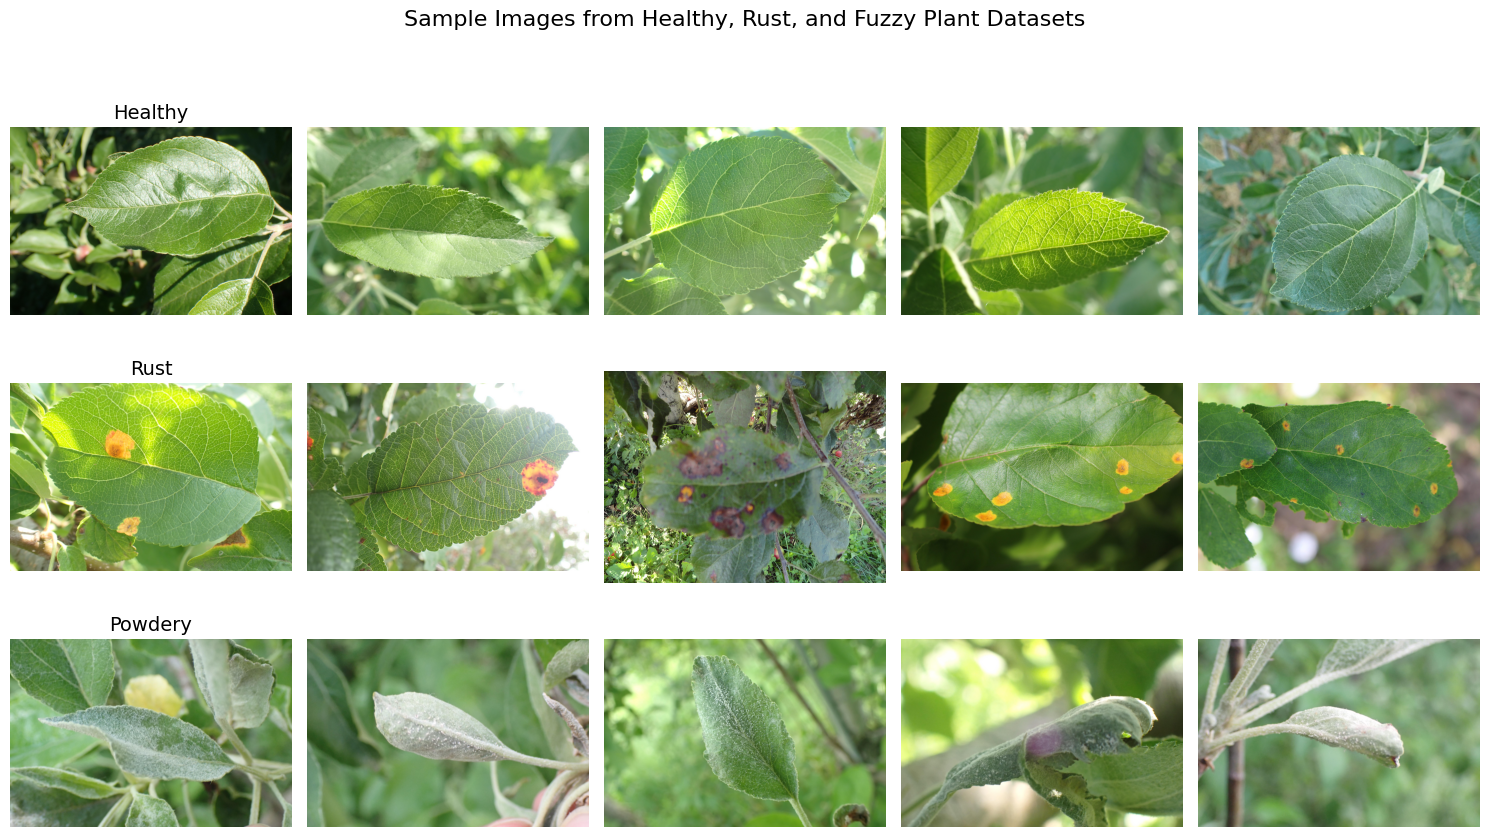

In [7]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_sample_images(directories, categories, num_samples=5):
    fig, axs = plt.subplots(len(categories), num_samples, figsize=(num_samples * 3, len(categories) * 3))
    fig.suptitle('Sample Images from Healthy, Rust, and Fuzzy Plant Datasets', fontsize=16)

    for i, category in enumerate(categories):
        category_path = os.path.join(directories[category])
        sample_files = random.sample(os.listdir(category_path), num_samples)
        
        for j, file in enumerate(sample_files):
            file_path = os.path.join(category_path, file)
            img = Image.open(file_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(category, fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Directories for the categories
directories = {
    'Healthy': 'Train/Healthy',
    'Rust': 'Train/Rust',
    'Powdery': 'Train/Powdery'
}

# Categories to plot
categories = ['Healthy', 'Rust', 'Powdery']

# Plot sample images
plot_sample_images(directories, categories)

In [19]:
import tensorflow
import random

seed = random.seed(42)  # Set the random seed to ensure reproducibility


train = tensorflow.keras.utils.image_dataset_from_directory(
    directory='Train', 
    labels='inferred', 
    label_mode='categorical', 
    class_names=['Healthy', 'Powdery', 'Rust'],
    batch_size=16, # number of processed samples before updating the model's weights 
    image_size=(256, 256),
    shuffle=True, 
    seed=seed,
    validation_split=0, # No need to create validation set
    crop_to_aspect_ratio=True # Resize the image without aspect ration distortion 
)

test = tensorflow.keras.utils.image_dataset_from_directory(
    directory='Test', 
    labels='inferred', 
    label_mode='categorical', 
    class_names=['Healthy', 'Powdery', 'Rust'],
    batch_size=16, # number of processed samples before updating the model's weights 
    image_size=(256, 256),
    shuffle=True, 
    seed=seed,
    validation_split=0, # No need to create validation set
    crop_to_aspect_ratio=True # Resize the image without aspect ration distortion 
)

validation = tensorflow.keras.utils.image_dataset_from_directory(
    directory='Validation', 
    labels='inferred', 
    label_mode='categorical', 
    class_names=['Healthy', 'Powdery', 'Rust'],
    batch_size=16, # number of processed samples before updating the model's weights 
    image_size=(256, 256),
    shuffle=True, 
    seed=seed,
    validation_split=0, # No need to create validation set
    crop_to_aspect_ratio=True # Resize the image without aspect ration distortion 
)

Found 1322 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


In [20]:
print(f'\nTrain Dataset:{train}')
print(f'\nTest Dataset:{test}')
print(f'\nValidation Dataset:{validation}')
# Images are 256x256 and 3 channels deep, all float32 types 


Train Dataset:<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Test Dataset:<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Validation Dataset:<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [21]:
# We need to rescale the images to be btw 0 and 1
from tensorflow.keras.layers import Rescaling
scalar = Rescaling(1./255)
train = train.map(lambda x, y: (scalar(x), y))
test = test.map(lambda x, y: (scalar(x), y))
validation = validation.map(lambda x, y: (scalar(x), y))

In [29]:
import tensorflow as tf

# Set the random seed
seed = 42

# Creating a data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
            factor=(-0.25, 0.3), 
            fill_mode='reflect', 
            interpolation='bilinear', 
            seed=seed), 
        tf.keras.layers.RandomBrightness(
            factor=(-0.45, 0.45), 
            value_range=(0.0, 1.0), 
            seed=seed), 
        tf.keras.layers.RandomContrast(
            factor=0.5, 
            seed=seed)
    ]
)

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
model = Sequential()
model.add(augmentation)

# Feature Learning Layers
# Add the Conv2D layer
model.add(Conv2D(
    filters=32, 
    kernel_size=(3, 3), 
    strides=1, 
    padding='same',  # Ensures same input and output dimensions when strides=1
    input_shape=(256, 256, 3)  # Define the input shape
))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))

# Add another Conv2D layer (double the filters and alternate btw kernal size )
model.add(Conv2D(
    filters=64, 
    kernel_size=(5, 5), 
    padding='same',  # Ensures same input and output dimensions when strides=1
))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(
    filters=128, 
    kernel_size=(3, 3), 
    padding='same',  # Ensures same input and output dimensions when strides=1
))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(
    filters=256, 
    kernel_size=(5, 5), 
    padding='same',  # Ensures same input and output dimensions when strides=1
))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(
    filters=512, 
    kernel_size=(3, 3), 
    padding='same',  # Ensures same input and output dimensions when strides=1
))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.3))

# Flattening the input tensors 
model.add(Flatten())

# Fully connected layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer (matching the number of class we have/classification layer)
model.add(Dense(3, activation='softmax'))

In [40]:
# Compiling the model 
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, mode='max', 
                               restore_best_weights=True)

checkpoint=ModelCheckpoint('best_model.h5', 
                           monitor='val_accuracy', 
                           save_best_only=True)

83/83 [==============================] - ETA: 0s - loss: 227.5527 - accuracy: 0.6135

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 131s 2s/step - loss: 227.5527 - accuracy: 0.6135 - val_loss: 205.6126 - val_accuracy: 0.3333
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


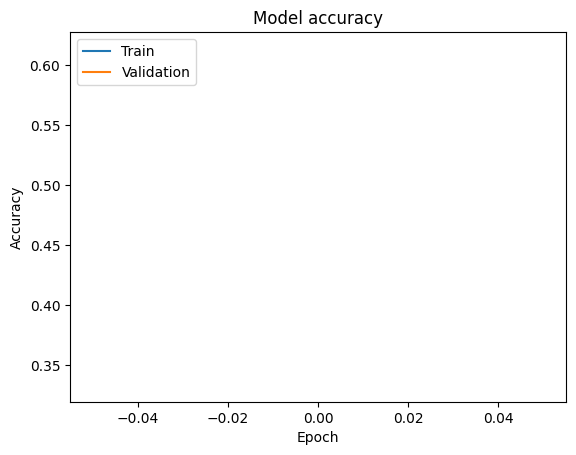

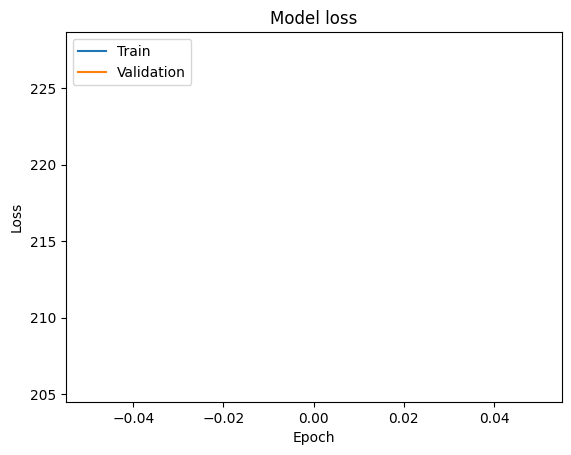

In [43]:
history = model.fit(train, epochs=1, batch_size=16,
                    validation_data=validation,
                    callbacks=[early_stopping, checkpoint])

# Print the keys in the history object
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
model.load_weights('best_model.h5')

In [46]:
preds = model.predict(test)
test_loss, test_acc = model.evaluate(test)

print('\nTesting Loss:', test_loss)
print('\nTesting Accuracy:', test_acc)



10/10 [==============================] - 5s 269ms/step - loss: 202.7995 - accuracy: 0.3267

Testing Loss: 202.79945373535156

Testing Accuracy: 0.3266666531562805
